# RLHF - An Independent Illustration

**Author:** [Abhor Gupta](https://in.linkedin.com/in/abhor-gupta-565386145) | **Published on**: 14 March, 2024 (😊 π day)
<hr>

Reinforcement learning from human feedback (RLHF) is a transformative technique that enables us to fine-tune large language models (LLMs) or transformer-based models for improved alignment with our intended goals. This approach goes beyond the standard techniques that train LLMs on massive volumes of text data. RLHF uses human feedback to teach LLMs how to better adhere to our preferences and values.

There are several very well written blogs on the topic - [here](https://medium.com/towards-generative-ai/reward-model-training-2209d1befb5f), [here](https://medium.com/@madhur.prashant7/rlhf-reward-model-ppo-on-llms-dfc92ec3885f) and [here](https://huggingface.co/blog/rlhf). I am especially fond of the one written by Chip Huyen [here](https://huyenchip.com/2023/05/02/rlhf.html). **The intention behind writing this is to understand RLHF using a simple and _mostly_ self-contained implementation to solve a demonstrative problem.** Let it be sufficiently trivial that we may open up our model and visually observe some effects of RLHF using different techniques.

## Overview

Let us first go over some basics.

### Training LLMs

Can't help but love this _beautiful_ depiction of RLHF among the broader spectrum of an LLM's training, by twitter.com/anthrupad.  

![](https://huyenchip.com/assets/pics/rlhf/2-shoggoth.jpg)

The image above shows the different methods of training an LLM, their "size" in terms of the space of outputs they represent and their "quality" in terms of their social acceptance to humans:

1. **Unsupervised Learning**: _Train an LLM on a massive corpus of raw text; this teaches the LLM a language - the fundamentals of its structure, grammer and relationship between words._ In terms of its objective, the LLM is trained to predict the next word in a context.  
But! Though an LLM may know a language, it doesn't necessarily know how to converse. In its space of outputs, it is aware of what it _can_ do, but not necessarily what it _should_ do. It is like the Shoggoth, massive but ugly.  
2. **Supervised Fine-tuning**: _Tailor the LLM to specific tasks like translation, question-answering, or summarization._ Here, the LLM is trained on a set of input-output pairs demonstrating the task.  
Following the example from the point above, this is akin to teaching the LLM how to converse. Its output space here is refined to answer in specific ways, perhaps with domain specific know-how, or in accordance to a particular task. This is like the deformed human face, you'll accept it but it's not necessarily very pleasing.
3. **RLHF**: _Refine the LLM's output to better align with human values, preferences, and safety guidelines._ The training here involves giving feedback signals on the LLM's output to guide it to some desired behavior.  
Following the same context from (1) and (2), after it has learnt language and knows how to converse, it learns to adhere to the social norms. Within its output space, this is the refinement that narrows down the conversation ability of the LLM to answer in a way that pleases its general reader - ethical speech, truthful statements, intelligent use of vocabulary etc. It is the smiley face that you want to talk to. :)

For the scope of this notebook, we will only be exploring RLHF. Supervised training will be a part - though it is more a requirement for the sake of thoroughness, than an intented guide on the topic. Therefore, I'll be using a very simple supervised pretraining that is closer to the description of supervised fine-tuning above, than unsupervised learning.

### RLHF components

A complete RLHF pipeline requires the following components:

1. **A pre-trained base model**: We begin with a pre-trained LLM. This is a powerful language model that has already learned the intricacies of language structure from vast amounts of text data. This may be followed by supervised fine-tuning to attune the LLM to a specific task like question-answering or summarization.
2. **Training a reward model from human feedback**: We then create a "reward model" specifically designed to capture human preferences. This involves gathering human feedback on various LLM outputs, where people rate the responses based on their desired qualities like helpfulness, safety, and adherence to instructions. By analyzing this feedback, the reward model learns to assign scores to future LLM responses, essentially mimicking human judgment.
3. **Fine tuning using Reinforcement Learning**: Finally, we put the LLM and the reward model to work together. When presented with a prompt, the LLM generates multiple potential responses. Each response is then analyzed by the reward model, which assigns a score based on its learned understanding of human preferences. Finally, a reinforcement learning algorithm like PPO uses these scores to fine-tune the LLM's internal parameters. Responses that received higher scores become more likely to be generated in the future, while those with lower scores are gradually downplayed. This iterative process progressively aligns the LLM's outputs with human expectations and values.

This pipeline effectively utilizes human feedback to bridge the gap between raw LLM capabilities and human-desired outcomes. It allows us to shape these powerful language models into not just masters of language, but also responsible and valuable tools aligned with our needs.

### Applications of RLHF

The most prevelant example of RLHF being applied in AI is for text generation to align chatbots with human preferences ([InstructGPT](https://openai.com/research/instruction-following), [ChatGPT](https://openai.com/blog/chatgpt), [Gemini](https://blog.google/technology/ai/google-gemini-ai/) are famous examples). Similarly, RLHF has seen application in image generation as well ([ImageReward](https://arxiv.org/abs/2304.05977), [DPOK](https://arxiv.org/abs/2305.16381)). Though limited, some research groups have also explored its application in games  ([DeepMind](https://deepmind.google/discover/blog/learning-through-human-feedback/) and [OpenAI](https://openai.com/research/learning-from-human-preferences)).

Even though currently the applications of RLHF in AI are limited, the scope for RLHF is much wider.

Do you use e-commerce websites like Amazon? Do you use Uber for requesting cabs? Do you use Google Maps for deciding which restaurant, bar or hospital to visit? You must have seen ratings for products, or people, or services, or food. You likely would have given some yourself. These are all examples of human feedback. And when these affect the product or service to comform to user satisfaction, it is also a form of RLHF.

Take, for instance, cooking robots are a thing now ([Moley](https://www.moley.com/), [Nymble](https://www.eatwithnymble.com/)). For the food that is cooked by the robots based on some recipe, the recipe can be adjusted for duration of cooking, quantity of spices etc for user preference based on their feedback. Self-driving cars are also real now ([Waymo](https://waymo.com/), [Tesla](https://www.tesla.com/support/autopilot)). Based on customer's feedback, the ride be adjusted to be faster/slower, less jerky, smoother maneuverability.

In the next section, we will establish a small toy problem to solve using a tiny LLM. Then we will dive into each of the RLHF concepts in detail along with some code to establish an implementational understanding as well some nice visualizations to complement our findings.

## Problem Statement

To keep the scale of things simple, let us work with a "language" of numbers. Our vocabulary consist of digits 0-9 as well as a special digit 10 that separates our input and output.

Typically for large LLMs, the language training is followed by a task specialisation training like question-answering before moving on to RLHF. To keep things simple, we avoid differentiating between language training and task specialisation and do a supervised training once to get our base model.

### Language (supervised learning)

The structure of the language is that for the current output to be generated, one of the last four digits (in the whole sequence of input+output) is chosen and its increment modulo 10 is outputted.

Given $a_1, a_2, ..., a_{n-1}, a_n$, $\forall n > 4$,
$$a'_{n+1} \sim \{a_{n-3}, a_{n-2}, a_{n-1}, a_{n}\}$$
$$a_{n+1} = (a'_{n+1} + 1)\ \%\ 10$$

For example,  
Input: 4, 5, 9, 1

Generation:  
<u>4, <span style="color:red">5</span>, 9, 1</u>, 10, **6**  
4, <u>5, 9, <span style="color:red">1</span></u>, 10, <u>6</u>, **2**  
4, 5, <u>9, 1</u>, 10, <u><span style="color:red">6</span>, 2</u>, **7**  
4, 5, 9, <u>1</u>, 10, <u>6, 2, <span style="color:red">7</span></u>, **8**

The underlined digits are the sampling set for the output. The digit marked in red is the digit sampled. Finally, the digit bolded at the end of the sequence is generated as the increment of the sampled digit.

### Alignment (RLHF)

Now we need a "preference" to incorporate. Mathematically, we wish to adjust the probability of some generation rule learned during the previous step.

For this toy example, let's change only the generation of the first output token to be the increment of the last input token.

That is, given $a_1, a_2, ..., a_{n-1}, a_n$, $\forall n > 4$,
$$
    a_{n+1}=
\begin{cases}
    a_n + 1,& \text{if } {a_{n+1}} = y_1\\
    (a'_{n+1} + 1)\ \%\ 10, & \text{otherwise}
\end{cases}
$$

Where $y_1$ is the first output token.

Considering the same example as above,  
Input: 4, 5, 9, 1

Generation:  
4, 5, 9, <u><span style="color:red">1</span></u>, 10, **2** (notice the change in underline)  
4, <u>5, 9, <span style="color:red">1</span></u>, 10, <u>2</u>, **2**  
4, 5, <u>9, 1</u>, 10, <u><span style="color:red">2</span>, 2</u>, **3**  
4, 5, 9, <u>1</u>, 10, <u>2, 2, <span style="color:red">3</span></u>, **4**  

For the first generation step, the model will only sample from the last digit and continue the original rule thereafter. Notice that except for the first generation step, the rest of the outputs are sampled from the same positions as the earlier example, yet the entire sequence has changed. Thus, though we wish to preserve the rule for the rest of the outputs, the actual outputs are not independent of the first output. Therefore, this small change in the output of a single token can have a cascading effect and lead to very different generations.

This is in line with the spirit of RLHF, where say, if we want to reduce the toxicity, reducing the probability of toxic words will have a cascading effect and we do not need to affect the probability of several thousands of unrelated words.

## Code and Commentary

Before RLHF: _Enough talking, show me the code!_  
After RLHF: _You've explained what we're doing here well enough. We would like to move on to the implementational details._

😉

### Supervised pre-training

First we learn the language using supervised learning. I'm using Karpathy's [minGPT](https://github.com/karpathy/minGPT/tree/master) for the LLM and supervised training.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/pretraining.png)

Source: [HuggingFace - RLHF blog](https://huggingface.co/blog/rlhf)

_Imports --_

> **_NOTE:_**  You can find this notebook and related code [here](https://github.com/InFoCusp/llm_seminar_series/tree/main/session_4/part_2_finetuning_lms_to_human_preferences).

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
import numpy as np
set_seed(3407)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

_Hyperparams for size of vocab and length of input --_

In [ ]:
VOCAB_SIZE = 10
INPUT_SIZE = 4

_Class for generating training pairs for supervised language learning --_

In [ ]:
class SupervisedDataset(Dataset):
    """
    Problem: Look at last 4 digits and sample one of them to output its increment.

    Input: 3 8 1 4
    Possible ouputs: 2 2 3 5 || 5 9 6 0 || 2 9 5 3 etc

    Which will feed into the transformer concatenated as:
    input:  3 8 1 4 S 2 2 3
    output: I I I I 2 2 3 5
    where I is "ignore", and S is the separation token
    """

    def __init__(self):
        self.EOS = VOCAB_SIZE

    def __len__(self):
        return 10000 # ...

    def get_vocab_size(self):
        return VOCAB_SIZE+1 # normal vocab + serparation token

    def __getitem__(self, idx):
        inputs = torch.randint(VOCAB_SIZE, size=(INPUT_SIZE,), dtype=torch.long)
        ouptputs = []

        # Create input output pairs
        inp = np.random.randint(VOCAB_SIZE, size=(INPUT_SIZE,)).tolist()
        sol = []
        for i in range(INPUT_SIZE):
            sol.append((np.random.choice(inp[i:] + sol) + 1)%10)

        # concatenate the problem specification and the solution
        cat = torch.Tensor(inp + [self.EOS] + sol).long()

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()

        # we only want to predict at output locations, mask out the loss at the input locations
        y[:INPUT_SIZE] = -1
        return x, y

_Looking at one sample --_

In [ ]:
# Supervised dataset
st_dataset = SupervisedDataset()
st_dataset[0]

(tensor([ 4,  3,  7,  6, 10,  8,  4,  8]),
 tensor([-1, -1, -1, -1,  8,  4,  8,  5]))

_Create a GPT instance --_

In [ ]:
from mingpt.model import GPT

def get_model(block_size, vocab_size, output_size=None):
    '''
    block_size = length of input
    vocab_size = digits allowed
    output_size = length of output
    '''
    if output_size is None:
        output_size = vocab_size
    model_config = GPT.get_default_config()
    model_config.model_type = 'gpt-nano'
    model_config.vocab_size = vocab_size
    model_config.block_size = block_size
    model_config.output_size = output_size
    model = GPT(model_config)
    return model

st_model = get_model(INPUT_SIZE*2, st_dataset.get_vocab_size())

Set up training --

In [ ]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000
train_config.num_workers = 0
trainer = Trainer(train_config, st_model, st_dataset)

Training --

In [ ]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

Loss stabilizes around 1.25. It cannot go lower because we don't have fixed outputs. We are trying to have a probability distribution such that multiple outputs have equal probability of being sampled.

Now let us give the model a random input and see what the model has learned to generate as the next token --

In [ ]:
x, _ = st_dataset[0]
x = x[:INPUT_SIZE+1].reshape(1, -1)
print("Input:", x)
print("Possible outputs:", torch.arange(11)[torch.nn.Softmax(dim=-1)(st_model(x)[0])[0, -1] > 0.1])

Input: tensor([[ 0,  2,  8,  6, 10]])
Possible outputs: tensor([1, 3, 7, 9])


Works like a charm!

Let's save the model too. We'll need to load it later before we start the RL training --

In [ ]:
# Save model weights
torch.save(st_model.state_dict(), "models/minimal_RLHF_basic_supervised.pt")

### Training a reward model

Now we will train a reward model.

The data required to train the reward model is collected as preferences in the format:  
\<promp>, \<accepted_response>, \<rejected_response>  

The accepted and rejected responses are simply two difference generations by the supervised training model with human labels marking their preference among the two.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/reward-model.png)

Source: [HuggingFace - RLHF blog](https://huggingface.co/blog/rlhf)

I don't have the money to hire humans to do this labeling and neither the time myself to do it. :)  
So here's a dataset class that'll generate the required data for us--

In [ ]:
class PreferenceDataset(Dataset):
    """
    Same as MyDataset, except this has output as <x, y', y> where x and y are input output from MyDataset. y' is the output that is sampled
    from preferred distribution - and is preferred over y.
    """
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def get_vocab_size(self):
        return self.dataset.get_vocab_size()

    def __getitem__(self, idx):
        x, y = self.dataset[idx]

        _x = x[:INPUT_SIZE+1]
        _y_reject = torch.concat([y[-INPUT_SIZE:], torch.Tensor([11]).long()])
        _y_accept = _y_reject.clone()

        # Replace first element with increment of last digit in input
        _y_accept[0] = (_x[INPUT_SIZE-1] + 1) % 10
        if _y_accept[0] == _y_reject[0]:
            _y_reject[0] = (_y_accept[0] - np.random.randint(1, 10)) % 10

        return _x, _y_accept, _y_reject


Let's look at one datapoint in this dataset --

In [ ]:
pf_dataset = PreferenceDataset(st_dataset)
pf_dataset[0]

(tensor([ 8,  0,  3,  4, 10]),
 tensor([ 5,  4,  5,  5, 11]),
 tensor([ 1,  4,  5,  5, 11]))

The first tensor is the \<input>, the second is the \<accepted_reponse> and the last is the \<rejected_response>. Notice the \<accepted_response> and \<rejected_response> only differ in their first digits. Unlike a usual RLHF pipeline where the pretrained model would be used to generate the outputs to be ranked for preference, here we artifically generate the data to look like this for our convenience.

Finally, it is time to train the reward model. For this we use the following loss function:

$$loss = -log(\sigma(R_{acc} - R_{rej}))$$

Where $\sigma$ is the sigmoid function, $R_{acc}$ and $R_{rej}$ are the rewards obtained by passing the \<accepted_response> and \<rejected_response> through the reward model. The intuition behind the loss function is to increase the difference between the rewards of the two types of responses. This becomes clear by looking at the training plot below.

In [ ]:
import tqdm

# Hyperparams
epochs = 40
batch_size = 64
rm_lr = 1e-4
acc_list = []
rej_list = []

# Dataloader
train_loader  = DataLoader(pf_dataset, shuffle=False, batch_size=batch_size)

# Optimizer
reward_model = get_model(block_size=INPUT_SIZE*2+2, vocab_size=pf_dataset.get_vocab_size()+1, output_size=1)
rm_opt = torch.optim.Adam(reward_model.parameters(), lr=rm_lr)

# Training
reward_model.train()
for ep_i in tqdm.tqdm(range(epochs)):
    for b_i, batch in enumerate(train_loader):
        inp, acc, rej = batch

        # Get rewards
        r_acc = reward_model(torch.concat([inp, acc], dim=-1))[0][:, -1, 0]
        r_rej = reward_model(torch.concat([inp, rej], dim=-1))[0][:, -1, 0]

        # Loss and backprop
        loss = -torch.log(torch.nn.Sigmoid()(r_acc-r_rej)).mean()
        rm_opt.zero_grad()
        loss.backward()
        rm_opt.step()

        # Save for plotting
        acc_list.append(r_acc.mean().detach().item())
        rej_list.append(r_rej.mean().detach().item())

#     print(ep_i, np.mean(acc_list[-20:]), np.mean(rej_list[-20:]))

Text(0, 0.5, 'Reward (moving average)')

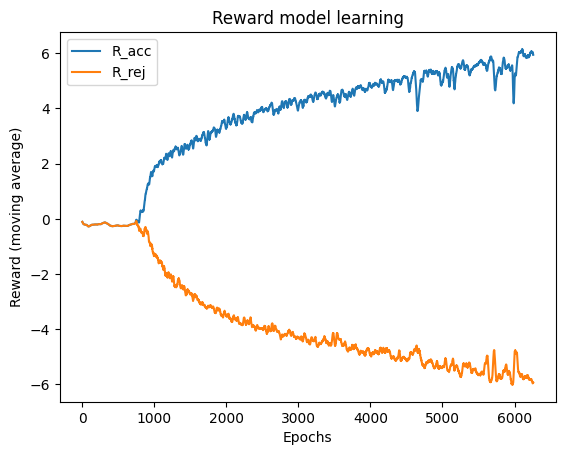

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(acc_list, 20), label="R_acc")
plt.plot(moving_average(rej_list, 20), label="R_rej")
plt.legend()
plt.title(f"Reward model learning")
plt.xlabel("Epochs")
plt.ylabel("Reward (moving average)")

Let's take a look at the kind of rewards the model generates for a fixed sequence and different values at the first position of the output.

In [ ]:
i = 0
for i in range(11):
    print(i, "||", reward_model(torch.Tensor([[ 6,  1,  7,  0, 10,  i,  5,  5,  6, 11]]).long())[0][0, -1, 0].item())

0 || -2.0374112129211426
1 || 4.983941078186035
2 || -0.8424915075302124
3 || -6.84158182144165
4 || -6.4326276779174805
5 || -6.820979118347168
6 || -6.832927703857422
7 || -6.83734130859375
8 || -6.613164901733398
9 || -4.2613844871521
10 || -6.424010753631592


Given the input sequence [6, 1, 7, 0], the first output token should be last_token+1 = 0 + 1 = 1. All other generations are "wrong", so the reward model gives positive reward for token 1 and negative rewards for others.

### RL fine-tuning

Finally, we have arrived at our final training that will use our reward model to update the supervised learning model using reinforecement learning.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/rlhf/rlhf.png)

Source: [HuggingFace - RLHF blog](https://huggingface.co/blog/rlhf)

Following is a function for calculating logprob given a model and outputs. This'll help us calculate loss for RL and KL Divergence. More details on these a few code blocks below --

In [ ]:
from torch.distributions import Categorical

def get_logprob(agent, outputs):
    '''
    Get the logprobs for outputs acc. to agent's policy.

    Args:
        agent: Actor network (or reference)
        outputs: output ids
            Shape = (sequence, tokens)

    returns
        logprob of outputs acc to agent's policy
            Shape = (sequence, tokens)
    '''
    logits = agent(outputs[:, :-1])[0][:, -INPUT_SIZE:, :]
    logprob = Categorical(logits=logits).log_prob(outputs[:, -INPUT_SIZE:])
    return logprob

Hyperparameters --

In [ ]:
# Hyperparams
epochs = 100
actor_lr = 1e-5
critic_lr = 1e-4
train_actor_iter = 4 # Train the networks this many times per epoch
train_critic_iter = 4
clip_ratio = 0.2 # PPO Clip
gamma = 0.99 # Discount factor
kl_beta = 1 # KL coeff for reward
save = False

# For plotting
rew_list = []
kl_list = []

Here we set up our models and optimizers. We typically need 3 models for RLHF training:

1. Actor: This is the LLM that we will fine-tune using reinforcement learning(RL). It is initialised as a copy of the pretrained model.
2. Reference: To prevent the actor's output distribution (or "policy" in RL terms) from diverging too much from the pretrained model's distribution, we need to apply some constraint on the distance/difference of the two distributions. For this, we keep this reference model which is a frozen copy of the pretrained model to calculate KL divergence during our RL training.
3. Critic: The critic network is also a copy of the base LLM but with the last layer replaced with a single output. This is used to estimate the value function, which is a component required to calculate the actor's loss.

In our simple problem statement, the rewards are given at the end of the sequence. Therefore, we don't need to estimate the value function and hence, don't train a critic network. For more information, see this [answer](https://stats.stackexchange.com/questions/380123/reinforcement-learning-what-is-the-logic-behind-actor-critic-methods-why-use) on StackExchange.

In [ ]:
# Actor
actor = get_model(block_size=INPUT_SIZE*2, vocab_size=st_dataset.get_vocab_size())
actor.load_state_dict(torch.load("models/minimal_RLHF_basic_supervised.pt")) # Load ST model from disk
# Reference
reference = get_model(block_size=INPUT_SIZE*2, vocab_size=st_dataset.get_vocab_size())
reference.load_state_dict(torch.load("models/minimal_RLHF_basic_supervised.pt")) # Clone of actor

# Optimizers
actor_opt = torch.optim.AdamW(actor.parameters(), lr=actor_lr)

# Set models to train/eval
reference.eval()
reward_model.eval()
actor.train()

At last, we come to our main RL training. We use PPO, a famous RL algorithm for fine-tuning our model along with a KL divergence penalty.

**PPO:**   
The main idea behind PPO is to induce stability in the training process by preventing large updates.

Let's look at the PPO loss:

$$L = \text{min}\biggl( \frac{\pi_{k+1} (a|s)}{\pi_{k} (a|s)} R, \text{  clip}\Bigl(\frac{\pi_{k+1} (a|s)}{\pi_{k} (a|s)}, 1-\epsilon, 1+\epsilon\Bigr) R\biggr)$$

Where $\pi_k$ represents the policy at $k$'th training step, R is reward and $\epsilon$ is a hyperparameter for clipping the policy update. I have partly modified the loss to prevent too many new ideas at once for beginners. This version is sufficient for our current case. To learn more about the PPO loss, look at [SpinningUp](https://spinningup.openai.com/en/latest/algorithms/ppo.html) and [Eric's article](https://medium.com/analytics-vidhya/coding-ppo-from-scratch-with-pytorch-part-1-4-613dfc1b14c8).

The PPO loss looks complicated but is fairly straightforward. To understand what the PPO loss does, consider the two cases:  
1. R is positive  
2. R is negative  

**Case 1**: R is positive.  
Then the loss reduces to
$$L = \text{min}\biggl( \frac{\pi_{k+1} (a|s)}{\pi_{k} (a|s)}, 1+\epsilon \biggr)R$$
So if the policy at the next training step is _increasing_ too far from the previous step, we clip it to $1+\epsilon$.

**Case 2**: R is negative.
Then the loss reduces to
$$L = \text{max}\biggl( \frac{\pi_{k+1} (a|s)}{\pi_{k} (a|s)}, 1-\epsilon \biggr)|R|$$
So if the policy at the next training step is _decreasing_ too far from the previous step, we clip it to $1-\epsilon$.

**KL Divergence:**  
[KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) is a measure of difference between two distributions. We use KL divergence penalty to ensure our actor's policy (probability distribution over next tokens) does not stray too far from the reference model's policy. For two distributions P and Q defined on the same sample space, $X$, the KL divergence is given by:

$$D_{KL}(P||Q) = \sum_{x \in X} P(x) log\biggl(\frac{P(x)}{Q(x)}\biggr)$$

The final reward used for PPO is then a linear combination of the scalar output from the reward model $R_{RM}$ and the value of KL divergence $R_{KL}$ with a hyperparameter $\beta$.

$$R = R_{RM} - \beta R_{KL}$$

Both of PPO and KL divergence are crucial components to the RLHF training due to the inherent fragile nature of RLHF.  Mainly, the issue lies with the reward model and the fact that it _cannot_ completely capture human preferences. The data used to train the reward model is generated using the base LLM's policy. Therefore, if the actor diverges too far from the base policy and the reward model is asked to give feedback for samples that do not come from the training distribution, we cannot predict the behaviour of the reward model. In fact, this exact issue often leads to adversarial training (see [Deepak's article](https://medium.com/@prdeepak.babu/reward-hacking-in-large-language-models-llms-c57abbc0cde7) on Reward Hacking in LLMs). This issue is avoided by taking small steps in PPO and using a KL penalty to prevent moving too far from base policy.

Now we have the RL code --

In [ ]:
# Dataloader - we use the same as reward model for now since we only need the inputs and it's in the correct format for what we want in RLHF training
# Can't use the supervised training's dataloader directly since the input has some part of output concatenated in that
ft_dataloader = train_loader

# Train
for ep in range(epochs):
    for b_i, batch in enumerate(ft_dataloader):
        # Get some inputs from supervised dataset (only inputs - we don't care about the ground truths anymore)
        inp, _, __ = batch

        # Generate output sequence
        out = actor.generate(inp, max_new_tokens=INPUT_SIZE, do_sample=True) # Not sampling since good and bad in our problem is fairly deterministic, otherwise prefer to sample.
        start_logprob = get_logprob(actor, out).detach()
        start_logprob = start_logprob.sum(-1)

        # Reward
        rew_out = torch.concat([out, torch.Tensor([[11]]*out.shape[0])], dim=-1).long() # Add [CLS] = 11
        rew = reward_model(rew_out)[0][:, -1, 0]
        rew_list.append(rew.mean().item())

        # Actor train loop
        for _iter_actor in range(train_actor_iter):
            # Get logprobs
            cur_logprob = get_logprob(actor, out)
            ref_logprob = get_logprob(reference, out)
            cur_logprob = cur_logprob.sum(dim=-1) # Summing because we don't have rewards for each timestep
            ref_logprob = ref_logprob.sum(dim=-1)

            # KL and reward update
            kl_div = (cur_logprob - ref_logprob).detach()
            rew = rew - kl_beta * kl_div

            # PPO loss
            ratio = torch.exp(cur_logprob - start_logprob)
            clip_rat = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio)
            actor_loss = -(torch.min(ratio * rew, clip_rat * rew)).mean()

            # Update actor
            actor_opt.zero_grad()
            actor_loss.backward(retain_graph=True)
            actor_opt.step()

        # Save kl div for plotting
        kl_list.append(kl_div.mean().item())

        # Eval
        if ep % 1 == 0 and b_i % 50 == 0:
            print(f"Epoch={ep} -- batch={b_i} || " + \
                    f"Reward={round(rew_list[-1], 2)} || " + \
                    f"KLD={round(kl_list[-1], 2)} || " + \
                    f"actor loss={round(actor_loss.item(), 2)}")
            print(out[0])
            print("#"*100)

Output is ommitted for brevity. Here is an image of some of the outputs:  

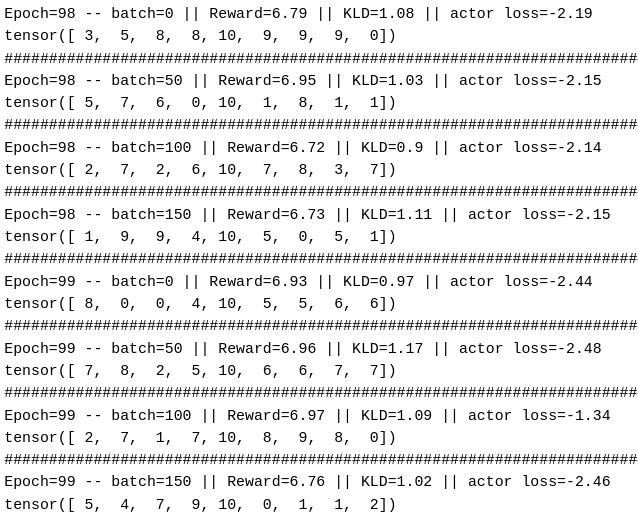

Save model --

In [ ]:
import datetime, os, json

save = True

# RUN TO SAVE MODEL
folder = f"models/08_min_rlhf_basic_{datetime.datetime.now().__str__()}"
os.makedirs(folder, exist_ok=True)

torch.save(reward_model, f"{folder}/reward_nodel.pt")
torch.save(reference, f"{folder}/reference.pt")
torch.save(actor, f"{folder}/actor.pt")

with open(f"{folder}/config.json", 'w') as f:
    json.dump({
        "epochs": epochs,
        "actor_lr": actor_lr,
        "critic_lr": critic_lr,
        "train_actor_iter": train_actor_iter,
        "train_critic_iter": train_critic_iter,
        "clip_ratio": clip_ratio,
        "gamma": gamma,
        "kl_beta": kl_beta,
    }, f)

Plot rewards --

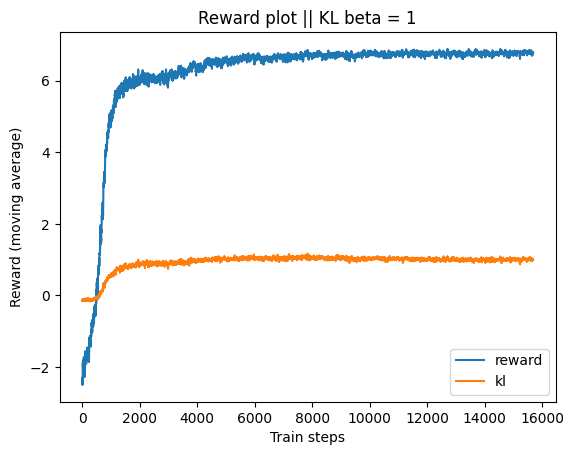

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(rew_list, 20), label="reward")
plt.plot(moving_average(kl_list, 20), label="kl")
plt.legend()
plt.title(f"Reward plot || KL beta = {kl_beta}")
plt.xlabel("Train steps")
plt.ylabel("Reward (moving average)")
if save:
    plt.savefig(f"{folder}/plot.png")
else:
    plt.show()

With our hyperparameters, we have maximized reward while maintaining a non-divergent KL. Looking at the outputs above, the model seems to behave the way we want it to.

Hurray!

## Explainability / Interpretability

First I run some visualizations on the base LLM to set the stage.

### Base model's visualizations

Let's look at some probability plots over the output tokens for different input lengths.

In [ ]:
x, y = torch.Tensor([[5, 7, 1, 5, 10]]).long(), torch.Tensor([[6, 2, 7, 3]]).long()

Text(0, 0.5, 'Probability')

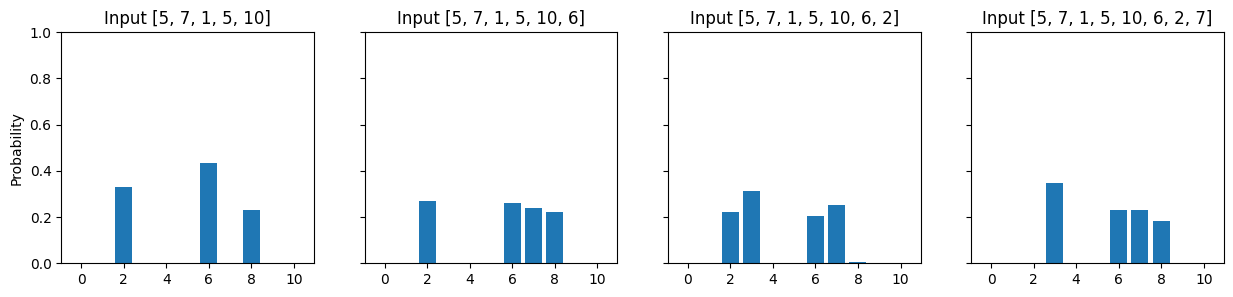

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
for i in range(4):
    _x = torch.concat([x, y[:, :i]], dim=1)
    axes[i].bar(np.arange(11), torch.softmax((reference(_x)[0][0, -1].detach()), dim=0).tolist())
    axes[i].title.set_text(f"Input {_x[0].tolist()}")
    axes[i].set_ylim([0, 1])
axes[0].set_ylabel("Probability")

The supervised model learns an almost equal probability over the increment of last 4 tokens. This was our intended behaviour.

The exact probabilities vary but are mostly within a some threshold of each other. For the first plot though, since the input contains two 5's, the probability of 6 is much higher than others.

Now, let's look at what the attention heads focus on. I'm using [BertViz](https://github.com/jessevig/bertviz) for visualizing attention weights.

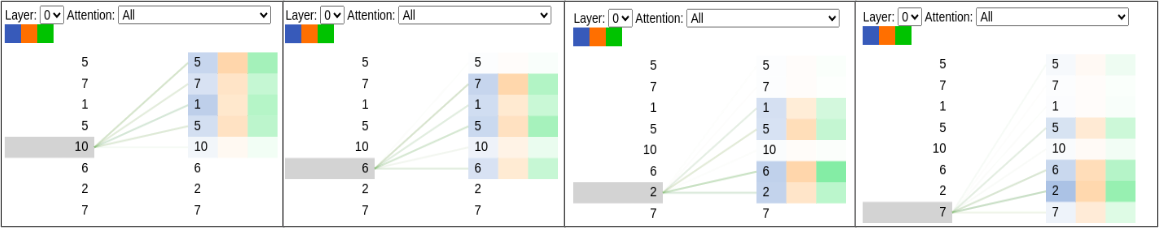

Here also, the model successfully learns to look at the last 4 input tokens while ignoring the separation token.

### Fine tuned model with beta = 1

We look at the same visualizations for the fine tuned model with $\beta = 1$.

Text(0, 0.5, 'Probability')

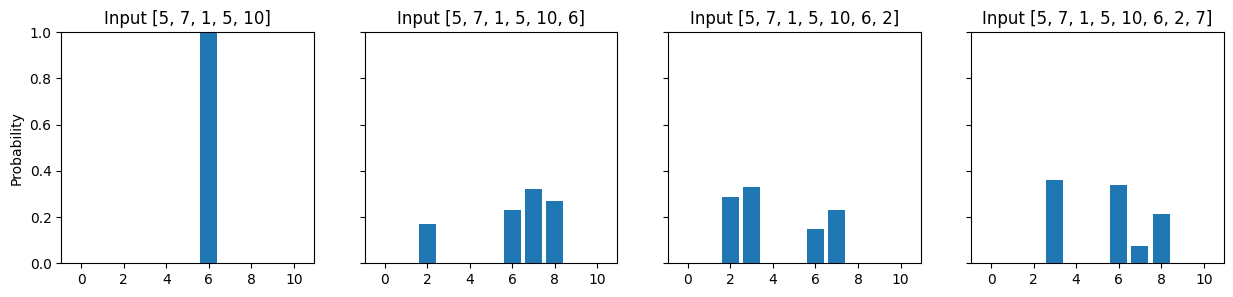

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
for i in range(4):
    _x = torch.concat([x, y[:, :i]], dim=1)
    axes[i].bar(np.arange(11), torch.softmax((actor(_x)[0][0, -1].detach()), dim=0).tolist())
    axes[i].title.set_text(f"Input {_x[0].tolist()}")
    axes[i].set_ylim([0, 1])
axes[0].set_ylabel("Probability")

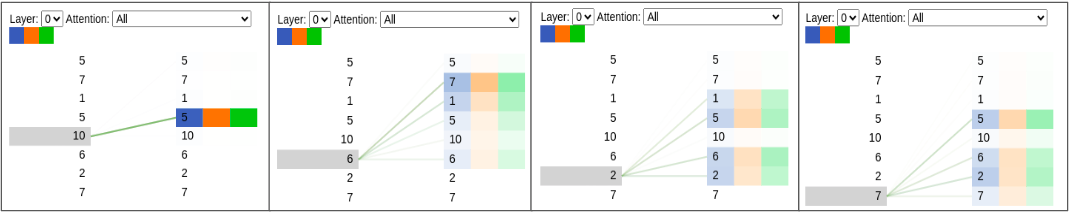

The model learnt to change the distribution over the first output token only. For the first plot and attention figure, the model learns to focus on a single token and output its increment. As for the rest of the tokens, it retains a similar behavior as the base model.

### Fine tuned model with beta 0

As as additional exercise, we also look at how the model behaves when no KL divergence penalty is applied.

I've run the training separately and compiled the results here.

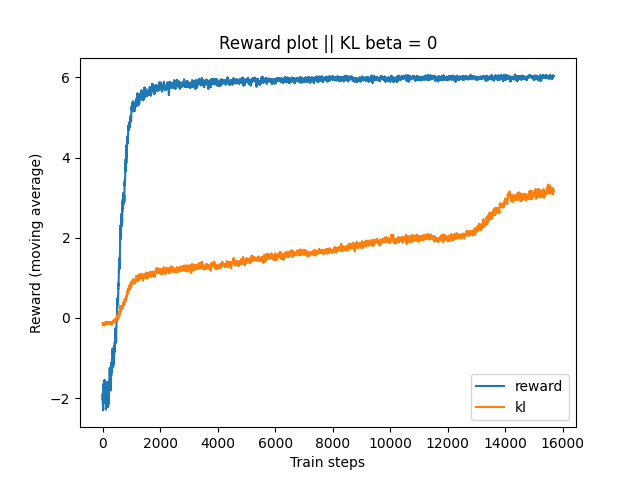

The reward hits the max but the KL is diverging, which means that the policy we are learning is moving further away from the base distribution as the training goes on. This is a result of not applying a penalty to KL divergence.

Text(0, 0.5, 'Probability')

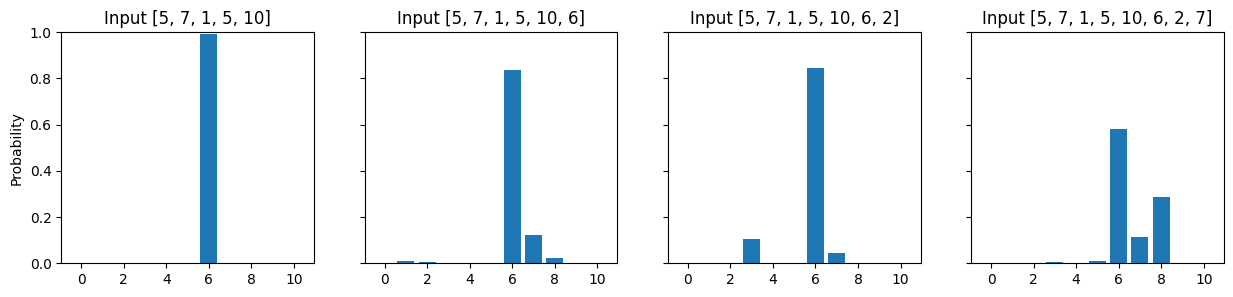

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
kl0_actor = torch.load("models/kl_beta=0/actor.pt")
for i in range(4):
    _x = torch.concat([x, y[:, :i]], dim=1)
    axes[i].bar(np.arange(11), torch.softmax((kl0_actor(_x)[0][0, -1].detach()), dim=0).tolist())
    axes[i].title.set_text(f"Input {_x[0].tolist()}")
    axes[i].set_ylim([0, 1])
axes[0].set_ylabel("Probability")

The first output is correct but the rest are all messed up. Let's look at the attention heads.


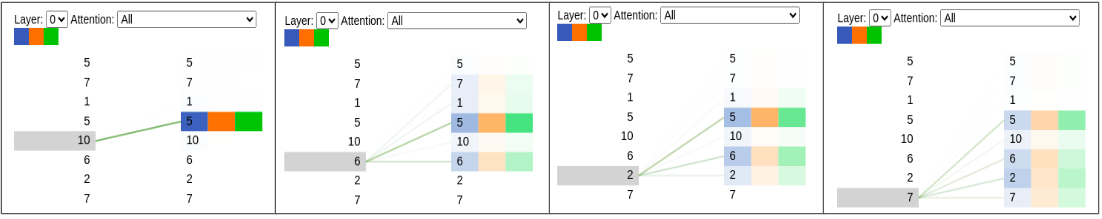

The model seems to have learnt to not look at tokens before the last input token. We can see this in the output probability plots too, that the tokens before 5 do not have high probability.
That is only for the input though. The effect of sampling from the output on the probability distribution is harder to interpret since we do not have a way to visualize how the weights affect the probability during the forward pass.